In [1]:
%loadlibs
from PS_Separated_utils import *

Loaded libraries:
	- numpy (np)
	- matplotlib.pyplot (plt)
	- torch
	- torch.nn (nn)
	- torch.optim (optim)
	- tqdm


In [34]:
nx = 1024
ny = 256
dx = 0.03
dt = 0.005
nt = 500
damping_size = 32
alpha = add_random_shapes(torch.empty((ny, nx)), base_value=4., num_shapes=20, damping_size=damping_size)
beta = add_random_shapes(torch.empty((ny, nx)), base_value=2., num_shapes=20, damping_size=damping_size)
alpha[-ny//10:] = 0
beta[-ny//10:] = 0
beta[beta>=alpha] /= 2.

In [35]:
v_xp, v_xs, v_zp, v_zs, u, w = initialise_conditions(nx, ny, (nx//2, 0))

In [36]:
trajectory = simulate(v_xp, v_xs, v_zp, v_zs, u, w, alpha, beta, dx, nx, ny, dt, nt, damping_size)

  0%|          | 0/500 [00:00<?, ?it/s]

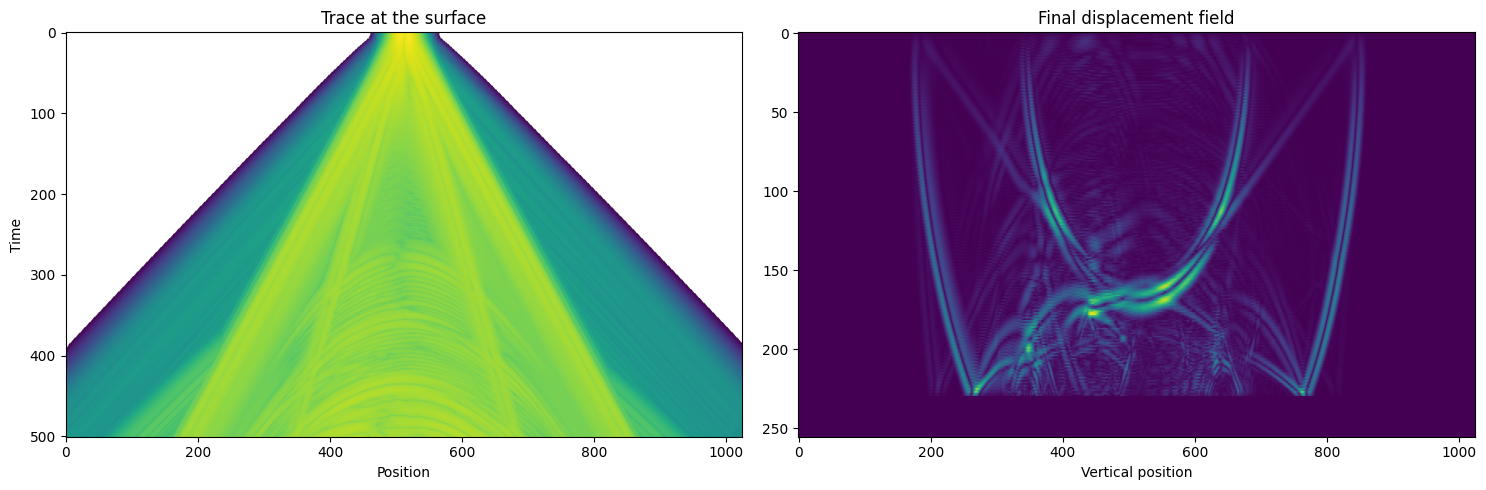

In [63]:
plot_trajectory(trajectory, nt)

In [64]:
import torch
import torch.nn as nn

class Dynamics(nn.Module):
    def __init__(self, nx, ny, damping_size):
        super().__init__()
        self.alpha = nn.Parameter(torch.full((ny, nx), 0.1))
        self.beta = nn.Parameter(torch.full((ny, nx), 0.1))
        self.sigma = damping(nx, ny, damping_size)  # Assuming precomputed damping factors

    def forward(self, v_xp, v_xs, v_zp, v_zs, u, w, dx, dt):
        # Compute gradients in one step
        du_dx, du_dz = gradient(u, dim=(0, 1), spacing=dx)
        dw_dx, dw_dz = gradient(w, dim=(0, 1), spacing=dx)

        # Compute A and B in-place
        A = du_dx.add(dw_dz)  # A = du/dx + dw/dz
        B = du_dz.sub(dw_dx)  # B = du/dz - dw/dx

        # Compute gradients of A and B
        dA_dx, dA_dz = gradient(A, dim=(0, 1), spacing=dx)
        dB_dx, dB_dz = gradient(B, dim=(0, 1), spacing=dx)

        # Precompute squared terms efficiently
        alpha_sq = torch.square(self.alpha)
        beta_sq = torch.square(self.beta)

        # Fused updates for better memory access
        v_xp.addcmul_(alpha_sq, dA_dx, value=dt)  # v_xp += dt * alpha^2 * dA/dx
        v_xs.addcmul_(beta_sq, dB_dz, value=dt)   # v_xs += dt * beta^2 * dB/dz
        v_zp.addcmul_(alpha_sq, dA_dz, value=dt)  # v_zp += dt * alpha^2 * dA/dz
        v_zs.addcmul_(beta_sq, dB_dx, value=-dt)  # v_zs -= dt * beta^2 * dB/dx

        # Update positions
        u.add_(dt, v_xp + v_xs)  # u += dt * (v_xp + v_xs)
        w.add_(dt, v_zp + v_zs)  # w += dt * (v_zp + v_zs)

        # Apply damping in-place for memory efficiency
        damping_factor = 1 - self.sigma
        v_xp.mul_(damping_factor)
        v_xs.mul_(damping_factor)
        v_zp.mul_(damping_factor)
        v_zs.mul_(damping_factor)

        return v_xp, v_xs, v_zp, v_zs, u, w


In [65]:
def simulate_optimisation(dynamics, v_xp, v_xs, v_zp, v_zs, u, w, dx, dt, nt):
    trajectory = [torch.concatenate((u.unsqueeze(-1), w.unsqueeze(-1)), axis=-1).unsqueeze(0)]
    for _ in (range(nt)):
        v_xp, v_xs, v_zp, v_zs, u, w = dynamics(v_xp, v_xs, v_zp, v_zs, u, w, dx, dt)
        trajectory.append(torch.concatenate((u.unsqueeze(-1), w.unsqueeze(-1)), axis=-1).unsqueeze(0))
    return torch.vstack(trajectory)

In [ ]:
torch.manual_seed(0)
dynamics = Dynamics(nx, ny, damping_size)
optimizer = optim.AdamW(dynamics.parameters(), lr=0.1)

loss_fn = nn.MSELoss()
losses = []
epochs = 2000

for epoch in (pbar:=tqdm(range(epochs))):
    optimizer.zero_grad()
    u_sim = simulate_optimisation(dynamics, v_xp.clone(), v_xs.clone(), v_zp.clone(), v_zs.clone(), u.clone(), w.clone(), dx, dt, nt)
    loss = loss_fn(trajectory[:, 0], u_sim[:, 0]).clamp(0, 1e2)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    pbar.set_description(f"Epoch {epoch} - nt: {nt} - Loss: {loss.item():.5e}")

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
plt.colorbar(ax[0].imshow(alpha, aspect='auto'))
plt.colorbar(ax[1].imshow(dynamics.alpha.detach(), aspect='auto'))
plt.colorbar(ax[2].imshow(beta, aspect='auto'))
plt.colorbar(ax[3].imshow(dynamics.beta.detach(), aspect='auto'))
plt.show()